The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


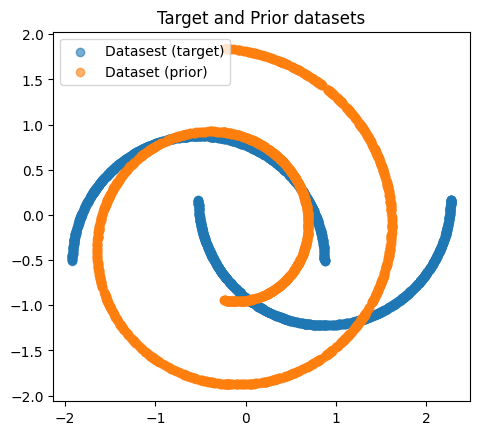

In [268]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

target_ds = TwoDimDataClass(dataset_type='moon', 
                            N=1000000, 
                            batch_size=1000)

prior_ds = TwoDimDataClass(dataset_type='swiss_roll',
                           N=1000000,
                           batch_size=1000)

Ntest = 2000
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and Prior datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (prior)'])

Loss: 12.287: 100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:52<00:00, 85.85it/s]


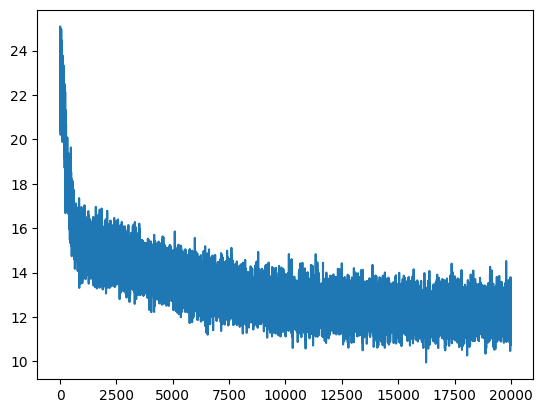

In [273]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 512),  nn.ReLU(),
            nn.Linear(512,512), nn.ReLU(),
            nn.Linear(512,512), nn.ReLU(),
            nn.Linear(512,512), nn.ReLU(),
            nn.Linear(512,256), nn.ReLU(),
            nn.Linear(256,2)
        )
    def forward(self, t, x):
        t = torch.atleast_2d(t) if (t.ndim == 0 or type(t) == int) else t
        t = t.unsqueeze(1) if t.ndim == 1 else t
        t = t.broadcast_to((x.shape[0],1)).float()
        xt = torch.cat((t,x), -1)
        return self.model(xt)

@torch.no_grad()
def compute_gaussian_product_coeff(sigma1, sigma2):
    """ Given p1 = N(x_t|x_0, sigma_1**2) and p2 = N(x_t|x_1, sigma_2**2)
        return p1 * p2 = N(x_t| coef1 * x0 + coef2 * x1, var) """
    denom = sigma1**2 + sigma2**2
    coef1 = sigma2**2 / denom
    coef2 = sigma1**2 / denom
    var = (sigma1**2 * sigma2**2) / denom
    return coef1, coef2, var

betas   = np.linspace(1e-4, 1e-5, 1000)
std_fwd = torch.tensor(np.sqrt(np.cumsum(betas)))
std_bwd = torch.tensor(np.sqrt(np.flip(np.cumsum(np.flip(betas)))))

mu_x0, mu_x1, var = compute_gaussian_product_coeff(std_fwd, std_bwd)
std_sb  = var.sqrt()
    
# sample from q(Xt | X0, X1) = p(Xn-1 | X0, Xn) in DDPM settings
def q_sampling(step, x0, x1): 
    mu0  = mu_x0[step].unsqueeze(1)
    mu1  = mu_x1[step].unsqueeze(1)
    std  = std_sb[step].unsqueeze(1)
    xt   = mu0*x0 + mu1*x1 + std*torch.randn_like(x0)
    return xt
    
def i2sb_loss_fn(step, x0, x1, eps_model):
    xt  = q_sampling(step, x0, x1).float()
    return torch.square(eps_model(step/1000, xt) - ((xt-x0)/std_fwd[step].unsqueeze(1))).mean()
      
def train(model, opt, loss_fn, n_iters, ds0, ds1, bsize=256):
    pbar = tqdm(range(n_iters), desc='loss: -', position=0, leave=True)
    all_losses = []
    N1 = len(ds1)
    for i in pbar:
        n  = torch.randint(0, 1000, [bsize])
        x0 = ds0[torch.randint(N1, (bsize,))]
        x1 = ds1[torch.randint(N1, (bsize,))]
    
        assert x0.shape == (bsize, 2) and x1.shape == x0.shape
        
        loss = loss_fn(n, x0, x1, model)
        all_losses.append(loss.item())
                
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 50 == 0:
            pbar.set_description("Loss: {:.3f}".format(loss.item()))
            
    plt.plot(all_losses)
    plt.show()

                
eps_model = MLP()
eps_opt   = torch.optim.Adam(eps_model.parameters(), lr=1e-5)
train(eps_model, eps_opt, i2sb_loss_fn, 20000, target_ds, prior_ds, bsize=512)

In [276]:
plot_Ntest = 200
x1 = prior_ds[0:plot_Ntest]

def p_posterior(nprev, n, x_n, x0):
    assert nprev < n
    std_delta = (std_fwd[n]**2 - std_fwd[nprev]**2).sqrt()
    mu_x0, mu_xn, var = compute_gaussian_product_coeff(std_fwd[nprev], std_delta)

    return mu_x0 * x0 + mu_xn * x_n

def ddpm_sampling(steps, pred_x0_fn, x1):
    xt = x1

    xs = []
    pred_x0s = []

    assert steps[0] == 0

    steps = steps[::-1]

    pair_steps = zip(steps[1:], steps[:-1])
    for prev_step, step in tqdm(pair_steps, desc='sampling', total=len(steps[1:])):
        assert prev_step < step, f"{prev_step=}, {step=}"

        # pred_x0 = pred_x0_fn(xt, step)
        t = torch.full((xt.shape[0],), step)/1000
        eps = eps_model(t, xt.float())
        pred_x0 = xt - std_fwd[step]*eps
        xt = p_posterior(prev_step, step, xt, pred_x0)

        pred_x0s.append(pred_x0.detach().cpu())
        xs.append(xt.detach().cpu())


    stack_bwd_traj = lambda z: torch.flip(torch.stack(z, dim=0), dims=(1,))
    return stack_bwd_traj(xs), stack_bwd_traj(pred_x0s)

steps = range(1000)
xs, pred_x0s = ddpm_sampling(steps, pred_x0_fn, prior_ds[0:plot_Ntest])

sampling: 100%|███████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 386.11it/s]


torch.Size([999, 200, 2])


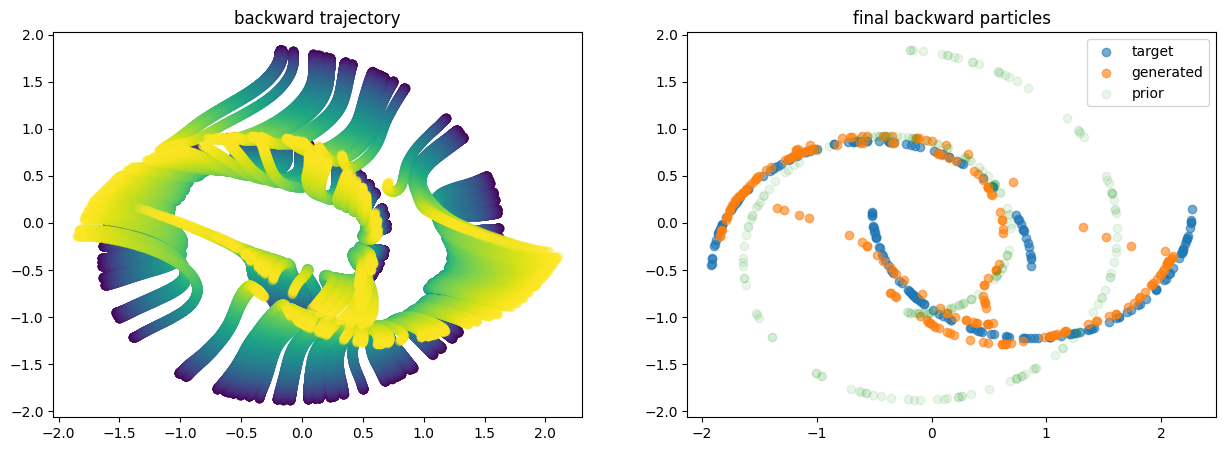

In [277]:
cmap = plt.get_cmap('viridis')

x_hist = xs
print(x_hist.shape)
fig = plt.figure(figsize=(15, 5), dpi=100)
ax = fig.add_subplot(1, 2, 1)
t_arr = np.linspace(0, 1, 999)

for k, tt in enumerate(t_arr):
    ax.scatter(x_hist[k, :, 0], x_hist[k, :, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
    
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "backward trajectory"
ax.set_title(strtitle)

out_true = target_ds[range(0, plot_Ntest)]
ax = fig.add_subplot(1, 2, 2)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(x_hist[0, :, 0], x_hist[0, :, 1], alpha=0.1)
ax.grid(False)
ax.set_aspect('auto', adjustable='box')
strtitle = "final backward particles"
ax.set_title(strtitle)
ax.legend(['target', 'generated', 'prior'])

In [ ]:
# sample from q(Xt | X0, X1) = p(Xn-1 | X0, Xn) in DDPM settings
def q_sampling(step, x0, x1): 
    betas   = np.linspace(1e-4, 1e-5, 1000)
    std_fwd = torch.tensor(np.sqrt(np.cumsum(betas)))
    std_bwd = torch.tensor(np.sqrt(np.flip(np.cumsum(np.flip(betas)))))

    mu_x0, mu_x1, var = compute_gaussian_product_coeff(std_fwd, std_bwd)
    std_sb  = var.sqrt()
    
    mu0  = mu_x0[step].unsqueeze(1)
    mu1  = mu_x1[step].unsqueeze(1)
    std  = std_sb[step].unsqueeze(1)
    xt   = mu0*x0 + mu1*x1 + std*torch.randn_like(x0)
    return xt

fig, ax = plt.subplots()
p0 = torch.tensor([1,0], dtype=float)
p1 = torch.tensor([-1,0], dtype=float)
t  = torch.tensor(range(100), dtype=torch.int64)
print(t[0])
pt = q_sampling(t, p0, p1)
print(pt.shape)
ax.scatter(p0[0], p0[1])
ax.scatter(p1[0], p1[1])
ax.scatter(pt[:,0], pt[:,1])
ax.legend(['target', 'prior', 'trajectory'])